In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from astropy.time import Time
from data import radio_data, radio_qs_epochs
from flux_utils import flux_conversion
from plots import fontsize, fig_width
from scipy import optimize

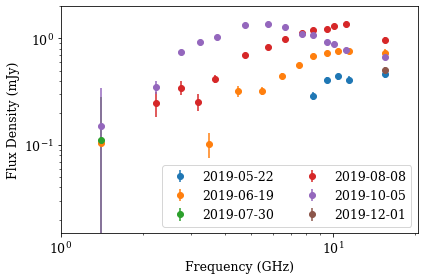

In [2]:
plt.figure(figsize=(fig_width, fig_width * 2./3.))
ax = plt.subplot(111)

for i, date_mjd in enumerate(sorted(list(set(radio_qs_epochs)))):
    data = radio_data[radio_qs_epochs == date_mjd]
    
    date = Time(date_mjd, format="mjd")
    date.format = "iso"
    date.out_subfmt = 'date'
    plt.errorbar(data["frequency"], data["flux"], yerr=data["flux_err"], marker="o", fmt=" ", label=date)

    
#     plt.errorbar(data["frequency"], data["flux"], yerr=data["flux_err"], marker="o", fmt=" ", label=date)
    
plt.xlim(1.0, 20.5)
plt.ylim(0.015, 2.)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (GHz)", fontsize=fontsize)
plt.ylabel("Flux Density (mJy)", fontsize=fontsize)
plt.legend(fontsize=fontsize, ncol=2, loc="lower right")
ax.tick_params(axis='both', which='both', labelsize=fontsize)
plt.tight_layout()
plt.savefig("plots/radio_spectrum.pdf")

In [3]:
def step(x):
    return 0.5 * (1. + np.sign(x))

# Follow procedure in https://arxiv.org/abs/astro-ph/0108027 (developed for GRB afterglows)
# Assume Spectrum 2 (i.e nu_m < nu_a < nu_c) 
# English: synchrotron frequency of minimal electron < synchrotron self-absorbtion frequency < cooling frequency

def f_tilda(nu_b, beta_1, beta_2, s=1.):
    """Equation 4 of https://arxiv.org/abs/astro-ph/0108027
    
    :param nu_b: Break frequency
    :param beta_1: Spectral slope 1
    :param beta_2: Spectral slope 2
    :param s: Smoothness parameter
    """
    return lambda x: (1. + (x/nu_b)**(s*(beta_1 - beta_2)))**(-1./s)

def radio_f(norm, p, nu_m, nu_a, s=1.5, nu_c=35.):
#     p = 2.33
            
    # Taken from equation 3
    
    beta_4 = 2.0
        
    f_4 = lambda x: norm * ((x/nu_m)**2 * np.exp(-s*((x/nu_m)**(2./3.))) + (x/nu_m) ** 2.5)
    
    # Taken from equation 4
    
    beta_d = 2.5
    beta_g = (1.-p)/2.
    beta_h = -0.5 * p
                  
    f_5 = f_tilda(nu_a, beta_d, beta_g, s=s)
    
    f_6 = f_tilda(nu_c, beta_g, beta_h, s=s)
    
    # Taken from equation 6
    
    penalisation = 1000. * (step(nu_m - nu_a + 2.) + step(nu_a - nu_c + 5.))
        
    model = lambda x: f_4(x) * f_5(x) * f_6(x) + penalisation * norm
#     model = lambda x: f_4(x) * f_5(x) + penalisation * norm


    return model

def fit_radio(nu, norm, p, nu_m, nu_a, s=1.5, nu_c=25.):
    return radio_f(norm, p, nu_m, nu_a, s=s, nu_c=nu_c)(nu)

def joint_radio(nu_list, p, norm_1, nu_m_1, nu_a_1, norm_2, nu_m_2, nu_a_2, s=1.5, nu_c=25.):
        
    return radio_f(norm, p, nu_m, nu_a, s=s, nu_c=nu_c)(nu)

def simple_radio_f(norm, nu_b, beta_1, beta_2, s=1.0):
    
    pen = norm * 1000. * (step(beta_2 - beta_1) + step(beta_2) + step(-3.5 - beta_2))
        
    return lambda x: norm * ((x/nu_b)**(-s*beta_1) + (x/nu_b)**(-s*beta_2))**(-1./s) + pen

def radio_peak(norm, nu_b, beta_1, beta_2, s=1.0):
    return nu_b * (-beta_1/beta_2)**(1./(s*(beta_1 - beta_2)))

def fit_break(nu, norm, nu_b, beta_1, beta_2, s=1.0):
    return simple_radio_f(norm, nu_b, beta_1, beta_2, s=s)(nu)

In [4]:
print(sorted(list(set(radio_qs_epochs))))

[58625.0, 58653.0, 58694.0, 58703.0, 58761.0, 58818.67542824074]


[ 1.78607699  4.82554924  1.72133192 -0.93603922  2.5707377 ]
5.275642162560617
[0.15698061 0.22611923 0.28011463 0.09572733 1.01689174]


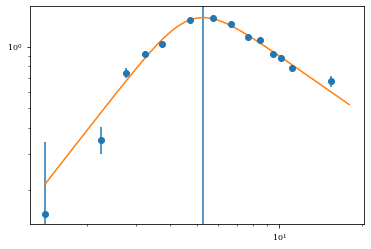

In [5]:
data = radio_data[radio_qs_epochs ==  58761.0]
date = Time(58653., format="mjd")
date.format = "iso"
date.out_subfmt = 'date'
plt.errorbar(data["frequency"], data["flux"], yerr=data["flux_err"], marker="o", fmt=" ", label=date)

p0 = [1.0, 8.0, 2.0, -1.0, 5.0]

popt, pcov = optimize.curve_fit(
        fit_break,
        data["frequency"],
        data["flux"],
        sigma=data["flux_err"],
        p0=p0,
        absolute_sigma=True,
    )

print(popt)

peak_f = radio_peak(*popt)

plt.axvline(peak_f)

print(peak_f)

perr = np.sqrt(np.diag(pcov))
print(perr)

ssc = simple_radio_f(*popt)
x = np.logspace(np.log10(1.4), np.log10(18), 100)

plt.plot(x, ssc(x))
plt.xscale("log")
plt.yscale("log")

<ipython-input-6-145a7b9b0620>:26: RuntimeWarning: invalid value encountered in double_scalars
  grad_2 = (np.log(data.iloc[-1]["flux"]) - np.log(peak["flux"]))/(np.log(data.iloc[-1]["frequency"]) - np.log(peak["frequency"]))


0.7803424442611859 -1.0
Results:  
 Break Frequency: 9.76 +/- 103.23 GHz 
 Beta 1: 2.55 +/- 152.57 
 Beta_2: -0.00 +/- 13.39
0.9508582341882861 -0.18365397708524814
Results:  
 Break Frequency: 9.15 +/- 8.38 GHz 
 Beta 1: 1.85 +/- 2.78 
 Beta_2: -0.33 +/- 5.23
1.0562318542339888 -0.995037774036991
Results:  
 Break Frequency: 13.60 +/- 110.23 GHz 
 Beta 1: 1.52 +/- 2.30 
 Beta_2: -3.50 +/- 72.27
1.5588664987521021 -0.7203193606664559
Results:  
 Break Frequency: 4.25 +/- 2.67 GHz 
 Beta 1: 2.45 +/- 4.06 
 Beta_2: -0.92 +/- 1.08


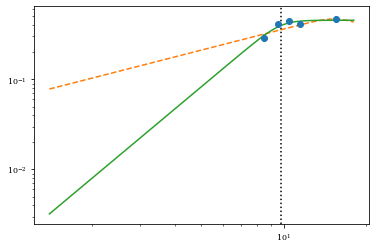

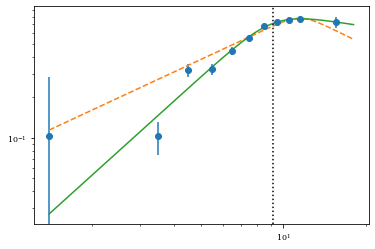

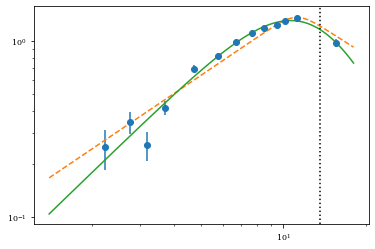

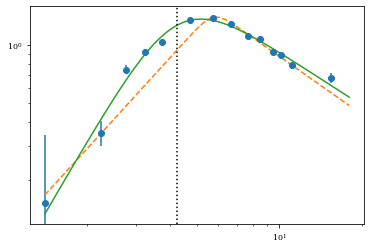

In [6]:
x = np.logspace(np.log10(1.4), np.log10(18), 100)

for mjd in sorted(list(set(radio_qs_epochs))):
    mask = radio_qs_epochs ==  mjd
    
    if np.sum(mask) > 4:
                
        data = radio_data[mask]
        data = data.sort_values("frequency")
        date = Time(mjd, format="mjd")
        date.format = "iso"
        date.out_subfmt = 'date'
        plt.figure()
        plt.errorbar(data["frequency"], data["flux"], yerr=data["flux_err"], marker="o", fmt=" ", label=date)

#         plt.plot(x, ssc(x))
        plt.xscale("log")
        plt.yscale("log")

        
        try:
            peak_ind = data["flux"].idxmax(axis=1)
            peak = data.loc[peak_ind]
            
            grad_1 = (np.log(peak["flux"]) - np.log(data.iloc[0]["flux"]))/(np.log(peak["frequency"]) - np.log(data.iloc[0]["frequency"]))
            grad_2 = (np.log(data.iloc[-1]["flux"]) - np.log(peak["flux"]))/(np.log(data.iloc[-1]["frequency"]) - np.log(peak["frequency"]))
            if np.isnan(grad_2):
                grad_2 = -1.0
            print(grad_1, grad_2)
            
            p0 = [1.1*peak["flux"], peak["frequency"], grad_1, -1.0, 8.0]
            
            ssc = simple_radio_f(*p0)
            plt.plot(x, ssc(x), linestyle="--")
            
            err = np.sqrt(data["flux_err"] + 0.1 * data["flux"])

            popt, pcov = optimize.curve_fit(
                    fit_break,
                    data["frequency"],
                    data["flux"],
                    sigma=err,
                    p0=p0,
                    absolute_sigma=True,
                )

            perr = np.sqrt(np.diag(pcov))

            ssc = simple_radio_f(*popt)

            print(
    f"Results:  \n Break Frequency: {popt[1]:.2f} +/- {perr[1]:.2f} GHz \n Beta 1: {popt[2]:.2f} +/- {perr[2]:.2f} \n Beta_2: {popt[3]:.2f} +/- {perr[3]:.2f}")
            if len(popt) > 5:
                print(f"nu_c: {popt[5]:.2f}")

            x = np.logspace(np.log10(1.4), np.log10(18), 100)

            plt.plot(x, ssc(x))
            plt.axvline(popt[1], linestyle=":", color="k")
            plt.xscale("log")
            plt.yscale("log")
            
        #         print(popt)

        except KeyError:
            pass

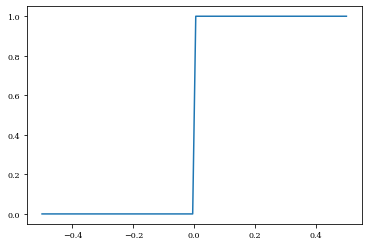

In [7]:
x = np.linspace(-0.5, 0.5, 100)
plt.plot(x, step(x))

In [16]:
p0 = [2.5, -1.0]

x_vals = []
y_vals = []
errs = []

for mjd in sorted(list(set(radio_qs_epochs))):
    mask = radio_qs_epochs ==  mjd
    
    if np.sum(mask) > 4:
                
        data = radio_data[mask]
        data = data.sort_values("frequency")
        peak_ind = data["flux"].idxmax(axis=1)
        peak = data.loc[peak_ind]
        
        x_vals.append(data["frequency"].to_numpy())
        y_vals += list(data["flux"])
        errs += list(data["flux_err"])

        p0.append(peak["flux"])
        p0.append(peak["frequency"])
        
x_vals = np.array(x_vals)
y_vals = np.array(y_vals)
errs = np.array(errs)
errs = np.sqrt(errs**2. + (0.2)**2.)
        
print(f"Guess is: {p0}")
print(x_vals, y_vals)
            

Guess is: [2.5, -1.0, 0.464, 15.5, 0.771, 11.511, 1.356, 11.161, 1.379, 5.761001]
[array([ 8.487001,  9.511001, 10.487   , 11.511   , 15.5     ])
 array([ 1.4     ,  3.499001,  4.487001,  5.511001,  6.487001,  7.511001,
        8.487001,  9.511001, 10.487   , 11.511   , 15.5     ])
 array([ 2.243   ,  2.755001,  3.179001,  3.691001,  4.737001,  5.761001,
        6.687001,  7.711001,  8.487001,  9.511001, 10.137   , 11.161   ,
       15.5     ])
 array([ 1.4     ,  2.243   ,  2.755   ,  3.243001,  3.755001,  4.737001,
        5.761001,  6.687001,  7.711001,  8.487001,  9.511001, 10.137   ,
       11.161   , 15.5     ])] [0.29  0.408 0.44  0.412 0.464 0.104 0.103 0.319 0.324 0.443 0.558 0.68
 0.73  0.756 0.771 0.73  0.249 0.345 0.255 0.419 0.698 0.829 0.987 1.117
 1.194 1.238 1.31  1.356 0.978 0.152 0.351 0.744 0.92  1.032 1.349 1.379
 1.285 1.111 1.074 0.921 0.884 0.785 0.676]


In [25]:
def joint_radio(x):
    
    beta_1 = x[0]
    beta_1 = 2.5
    
    beta_2 = x[1]
    norm_1 = x[2]
    nu_b_1 = x[3]
    norm_2 = x[4]
    nu_b_2 = x[5]
    norm_3 = x[6]
    nu_b_3 = x[7]
    norm_4 = x[8]
    nu_b_4 = x[9]
#     try:
#         s = x[10]
#     except KeyError:
    s = 1.0
    
    res = []
    
    nu_bs = [nu_b_1, nu_b_2, nu_b_3, nu_b_4]
    
    for i, nu in enumerate(x_vals):
        nu_b = nu_bs[i]
        norm = [norm_1, norm_2, norm_3, norm_4][i]
        res += list(simple_radio_f(norm, nu_b, beta_1, beta_2, s=s)(nu))
        
    res = np.array(res)
    
    diff = np.sum(((res - y_vals)/errs)**2.)
    
#     for i, nu in enumerate(nu_bs[1:]):
#         if nu > nu_bs[i]:
#             res *= 1000.
        
    return diff

In [26]:
res = optimize.minimize(
        joint_radio,
        p0
    )

err = np.sqrt(np.diag(res.hess_inv))

for i, p in enumerate(res.x):
    print(f"Parameter {i+1}: {p:.2f} +/- {err[i]:.2f}")

Parameter 1: 2.50 +/- 1.00
Parameter 2: -1.06 +/- 0.20
Parameter 3: 0.86 +/- 0.20
Parameter 4: 10.99 +/- 2.93
Parameter 5: 1.43 +/- 0.16
Parameter 6: 9.22 +/- 1.09
Parameter 7: 2.34 +/- 0.16
Parameter 8: 7.51 +/- 0.61
Parameter 9: 2.44 +/- 0.20
Parameter 10: 4.21 +/- 0.35


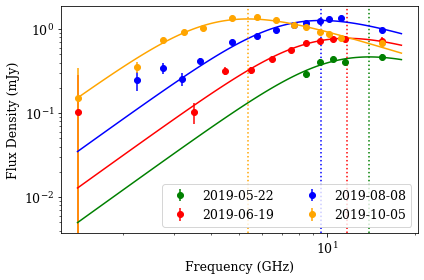

In [27]:
x = np.logspace(np.log10(1.4), np.log10(18), 100)

j = 2

peak_fs = []
peak_fluxes = []

cols = ["g", "r", "b", "orange"]

plt.figure()
ax = plt.subplot(111)


for mjd in sorted(list(set(radio_qs_epochs))):
    mask = radio_qs_epochs ==  mjd
    
    if np.sum(mask) > 4:
        
        ind = int(j/2) - 1
        
        col = cols[ind]
                
        data = radio_data[mask]
        data = data.sort_values("frequency")
        date = Time(mjd, format="mjd")
        date.format = "iso"
        date.out_subfmt = 'date'
        plt.errorbar(data["frequency"], data["flux"], yerr=data["flux_err"], marker="o", fmt=" ", label=date, color=col)
                     
        best_fit = [res.x[j], res.x[j+1], res.x[0], res.x[1], 1.0]
        ssc = simple_radio_f(*best_fit)
        
        peak_f = radio_peak(*best_fit)
        
        peak_fs.append(peak_f)
        peak_fluxes.append(ssc(peak_f))

        plt.plot(x, ssc(x), color=col)
        plt.axvline(peak_f, linestyle=":", color=col)
        j += 2

plt.xscale("log")
plt.yscale("log")
plt.legend(fontsize=fontsize)
plt.xlabel("Frequency (GHz)", fontsize=fontsize)
plt.ylabel("Flux Density (mJy)", fontsize=fontsize)
plt.legend(fontsize=fontsize, ncol=2, loc="lower right")
ax.tick_params(axis='both', which='both', labelsize=fontsize)
plt.tight_layout()
plt.savefig("plots/fit_radio_spectrum.pdf")

In [12]:
print(peak_fs)
print(peak_fluxes)

[14.196014242837597, 12.201382623396936, 9.975065596668484, 5.56672580824371]
[0.46810052872218944, 0.7843435869242245, 1.2767596314937135, 1.3292357335313087]
